In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import rioxarray as rxr


In [2]:
S1 = r'/Volumes/PhD/imagery/masters/sentinel-2/USGS/S2_refl_20171128_b5_8a_12.tif'
S2 = r'/Volumes/PhD/imagery/masters/sentinel-2/USGS/S2_refl_20171228_b5_8a_12.tif'

AV1 = r'/Volumes/PhD/imagery/masters/AVIRIS/171206_av_area_final_clip_warp_warp_warp.dat'
AV2 = r'/Volumes/PhD/imagery/masters/AVIRIS/171221_av_area_final_warp_warp.dat'

TF = r'/Volumes/PhD/imagery/masters/baer/thm2017_Basin_DFPredictions_15min_12mmh.shp'

mont_b = r'/Volumes/PhD/imagery/masters/hyper/ma_data.csv'

out = r'/Volumes/PhD/imagery/masters/output/NBR/'

In [ ]:
S1I = rxr.open_rasterio(S1, masked=True)
S2I = rxr.open_rasterio(S2, masked=True)

AV1I = rxr.open_rasterio(AV1, masked=True)
AV2I = rxr.open_rasterio(AV2, masked=True)

TF = gpd.read_file(TF)
#
mont_b = pd.read_csv(mont_b)


In [34]:
print(S1I.rio.crs)
print(AV1I.rio.crs)
TF = TF.to_crs(32611)
print(TF.crs)

EPSG:32611
EPSG:32611
EPSG:32611


In [47]:
WV = AV1I.coords['wavelength'].values
BD = AV1I.coords['band'].values
for BD, w1 in zip(BD, WV):
    print(f'Band: {BD}, Wavelength: {w1}')

Band: 1, Wavelength: 365.913666
Band: 2, Wavelength: 375.577667
Band: 3, Wavelength: 385.246674
Band: 4, Wavelength: 394.919647
Band: 5, Wavelength: 404.596649
Band: 6, Wavelength: 414.278656
Band: 7, Wavelength: 423.964661
Band: 8, Wavelength: 433.654663
Band: 9, Wavelength: 443.34967
Band: 10, Wavelength: 453.049652
Band: 11, Wavelength: 462.752655
Band: 12, Wavelength: 472.460663
Band: 13, Wavelength: 482.173645
Band: 14, Wavelength: 491.890656
Band: 15, Wavelength: 501.611664
Band: 16, Wavelength: 511.337646
Band: 17, Wavelength: 521.067688
Band: 18, Wavelength: 530.801636
Band: 19, Wavelength: 540.540649
Band: 20, Wavelength: 550.28363
Band: 21, Wavelength: 560.031677
Band: 22, Wavelength: 569.78363
Band: 23, Wavelength: 579.539673
Band: 24, Wavelength: 589.300659
Band: 25, Wavelength: 599.065674
Band: 26, Wavelength: 608.835632
Band: 27, Wavelength: 618.608643
Band: 28, Wavelength: 628.387634
Band: 29, Wavelength: 638.169678
Band: 30, Wavelength: 647.957642
Band: 31, Wavelength: 

In [36]:
#Subset the basins by montecito data
TF = TF[TF['BASIN_ID'].isin(mont_b['basin_id'].unique())]

In [40]:
# create NBR function
def nbr(image, band1, band2):
    
    # Calculate NBR
    nbr_value = (image.sel(band=band1) - image.sel(band=band2)) / (image.sel(band=band1) + image.sel(band=band2))
    return nbr_value

In [48]:
S2_pre = nbr(S1I, 2, 3) 
S2_post = nbr(S2I, 2, 3)
HM1_AV_pre = nbr(AV1I, 54, 193)
HM1_AV_post = nbr(AV2I, 54, 193)
OHM1_AV_pre = nbr(AV1I, 63, 218)
OHM1_AV_post = nbr(AV2I, 63, 218)

In [57]:
#clip each NBR image to the basin shapefile
BASIN_ID = []
S2_pre_mean = []
S2_post_mean = []
HM1_pre_mean = []
HM1_post_mean = []
OHM1_pre_mean = []
OHM1_post_mean = [] 
for idx, row in TF.iterrows():
    basin_id = row['BASIN_ID']
    BASIN_ID.append(basin_id)
    basin_geom = row['geometry']
    
    # Clip the NBR images to the basin geometry
    S2_pre_clipped = S2_pre.rio.clip([basin_geom], S2_pre.rio.crs)
    S2_pre_mean.append(S2_pre_clipped.mean().item())
    S2_post_clipped = S2_post.rio.clip([basin_geom], S2_post.rio.crs)
    S2_post_mean.append(S2_post_clipped.mean().item())
    HM1_AV_pre_clipped = HM1_AV_pre.rio.clip([basin_geom], HM1_AV_pre.rio.crs)
    HM1_pre_mean.append(HM1_AV_pre_clipped.mean().item())
    HM1_AV_post_clipped = HM1_AV_post.rio.clip([basin_geom], HM1_AV_post.rio.crs)
    HM1_post_mean.append(HM1_AV_post_clipped.mean().item())
    OHM1_AV_pre_clipped = OHM1_AV_pre.rio.clip([basin_geom], OHM1_AV_pre.rio.crs)
    OHM1_pre_mean.append(OHM1_AV_pre_clipped.mean().item())
    OHM1_AV_post_clipped = OHM1_AV_post.rio.clip([basin_geom], OHM1_AV_post.rio.crs)
    OHM1_post_mean.append(OHM1_AV_post_clipped.mean().item())

    # Save the clipped NBR images to files
    S2_pre_clipped_path = os.path.join(out, f'{basin_id}_S2_NBR_pre.tif')
    S2_post_clipped_path = os.path.join(out, f'{basin_id}_S2_NBR_post.tif')
    HM1_AV_pre_clipped_path = os.path.join(out, f'{basin_id}_HM1_AV_NBR_pre.tif')
    HM1_AV_post_clipped_path = os.path.join(out, f'{basin_id}_HM1_AV_NBR_post.tif')
    OHM1_AV_pre_clipped_path = os.path.join(out, f'{basin_id}_OHM1_AV_NBR_pre.tif')
    OHM1_AV_post_clipped_path = os.path.join(out, f'{basin_id}_OHM1_AV_NBR_post.tif')

    S2_pre_clipped.rio.to_raster(S2_pre_clipped_path)
    S2_post_clipped.rio.to_raster(S2_post_clipped_path)
    HM1_AV_pre_clipped.rio.to_raster(HM1_AV_pre_clipped_path)
    HM1_AV_post_clipped.rio.to_raster(HM1_AV_post_clipped_path)
    OHM1_AV_pre_clipped.rio.to_raster(OHM1_AV_pre_clipped_path)
    OHM1_AV_post_clipped.rio.to_raster(OHM1_AV_post_clipped_path)

In [58]:
# Create a DataFrame to store the results 
results_df = pd.DataFrame({
    'BASIN_ID': BASIN_ID,
    'S2_NBR_pre_mean': S2_pre_mean,
    'S2_NBR_post_mean': S2_post_mean,
    'HM1_AV_NBR_pre_mean': HM1_pre_mean,
    'HM1_AV_NBR_post_mean': HM1_post_mean,
    'OHM1_AV_NBR_pre_mean': OHM1_pre_mean,
    'OHM1_AV_NBR_post_mean': OHM1_post_mean
})
results_df

,BASIN_ID,S2_NBR_pre_mean,S2_NBR_post_mean,HM1_AV_NBR_pre_mean,HM1_AV_NBR_post_mean,OHM1_AV_NBR_pre_mean,OHM1_AV_NBR_post_mean
0,12042,0.442571,0.225971,0.461119,0.197917,0.616915,0.355829
1,12057,0.398171,-0.081135,0.411435,-0.161521,0.584498,-0.014987
2,12518,0.424253,0.215591,0.389390,0.157367,0.594453,0.346317
3,12524,0.440717,-0.018991,0.406119,-0.072642,0.598345,0.081522
4,12527,0.370094,0.008422,0.330186,-0.007624,0.523239,0.186588
5,12616,0.450108,0.364689,0.417812,0.300091,0.620515,0.516568
6,12860,0.395730,0.029963,0.361988,0.038037,0.569211,0.272639
7,12997,0.455815,0.032809,0.443146,0.072958,0.646058,0.291286
8,13281,0.279393,0.038014,0.309502,0.010090,0.454247,0.163421
9,17346,0.386729,-0.099144,0.407433,-0.152434,0.568602,-0.001542


In [59]:
# Save the results DataFrame to a CSV file
output_csv_path = os.path.join(out, 'basin_nbr_means.csv')
results_df.to_csv(output_csv_path, index=False)

In [6]:
out2 = r'/Volumes/PhD/imagery/masters/output/manuscript_figs/'

In [29]:
Sent_pre = r'/Volumes/PhD/imagery/masters/output/NBR/17346_S2_NBR_pre.tif'
Sent_pre_I = rxr.open_rasterio(Sent_pre, masked=True)
Sent_post = r'/Volumes/PhD/imagery/masters/output/NBR/17346_S2_NBR_post.tif'
Sent_post_I = rxr.open_rasterio(Sent_post, masked=True)
Sent_dnbr = r'/Volumes/PhD/imagery/masters/output/dNBR/basin_17346_dNBR.tif'
Sent_dnbr_I = rxr.open_rasterio(Sent_dnbr, masked=True)

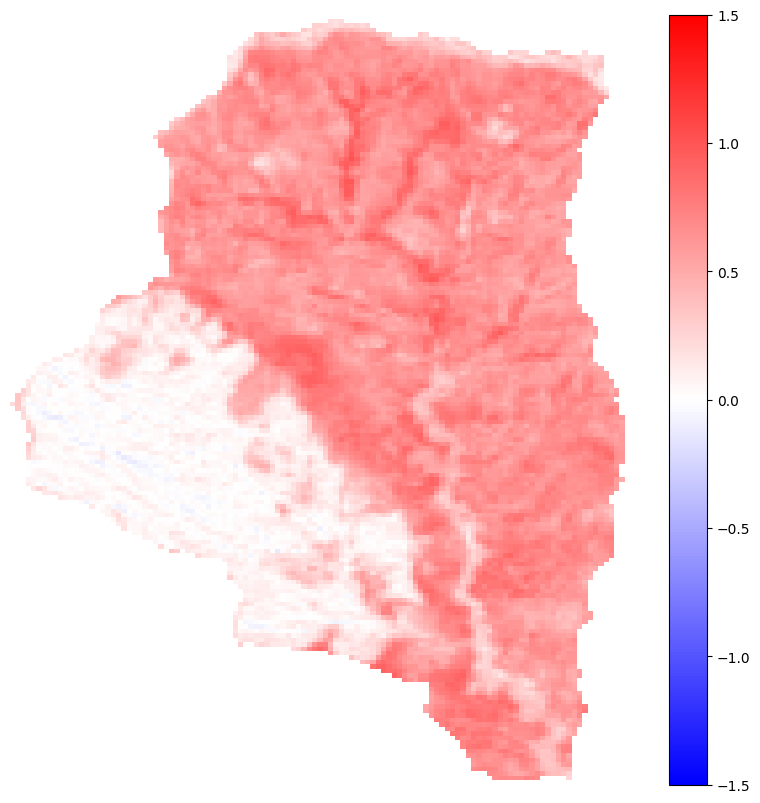

In [32]:
# plot each individual NBR image, turn off the axis, and save to out2
plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt
Sent_dnbr_I.plot(cmap='bwr', vmin=-1.5, vmax=1.5)
plt.axis('off')
plt.title('')
plt.savefig(os.path.join(out2, 'Sentinel_2_dNBR.svg'), bbox_inches='tight', pad_inches=0.1, dpi=600)




In [9]:
AV_Hpre = r'/Volumes/PhD/imagery/masters/output/NBR/17346_HM1_AV_NBR_pre.tif'
AV_Hpre_I = rxr.open_rasterio(AV_Hpre, masked=True)
AV_Hpost = r'/Volumes/PhD/imagery/masters/output/NBR/17346_HM1_AV_NBR_post.tif'
AV_Hpost_I = rxr.open_rasterio(AV_Hpost, masked=True)
AV_HdNBR = r'/Volumes/PhD/imagery/masters/output/hyper_compare/HM1/Basin_17346_dNBR.tif'
AV_HdNBR_I = rxr.open_rasterio(AV_HdNBR, masked=True)


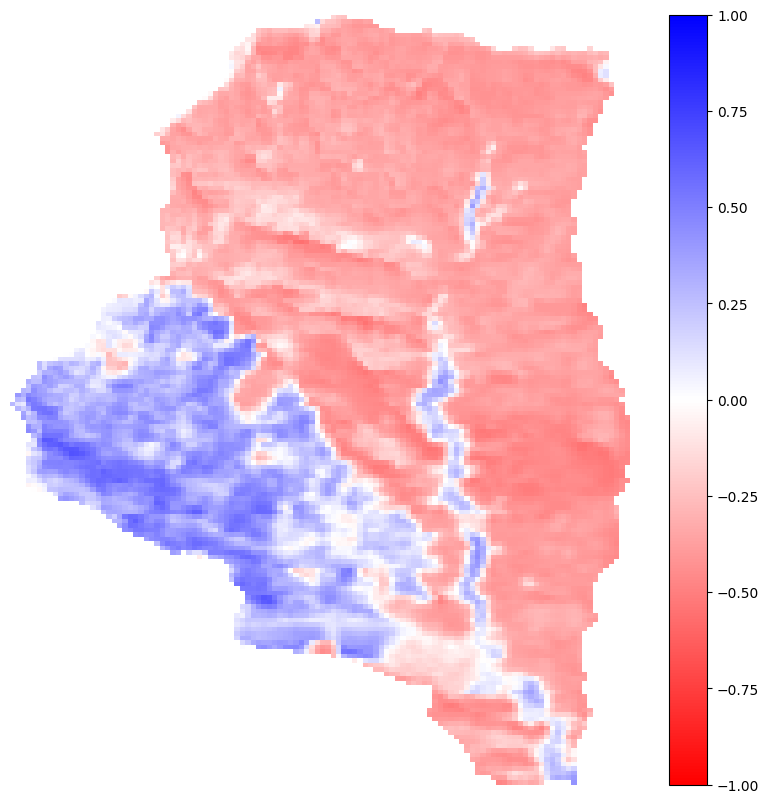

In [36]:
# plot each individual NBR image, turn off the axis, and save to out2
plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt
AV_Hpost_I.plot(cmap='bwr_r', vmin=-1, vmax=1)
plt.axis('off')
plt.title('')


plt.savefig(os.path.join(out2, 'AVIRIS_HNBR_Post.svg'), bbox_inches='tight', pad_inches=0.1, dpi=600)

In [10]:
AV_Opre = r'/Volumes/PhD/imagery/masters/output/NBR/17346_OHM1_AV_NBR_pre.tif'
AV_Opre_I = rxr.open_rasterio(AV_Opre, masked=True)
AV_Opost = r'/Volumes/PhD/imagery/masters/output/NBR/17346_OHM1_AV_NBR_post.tif'
AV_Opost_I = rxr.open_rasterio(AV_Opost, masked=True)
AV_OdNBR = r'/Volumes/PhD/imagery/masters/output/hyper_compare/OHM1/Basin_17346_dNBR.tif'
AV_OdNBR_I = rxr.open_rasterio(AV_OdNBR, masked=True)

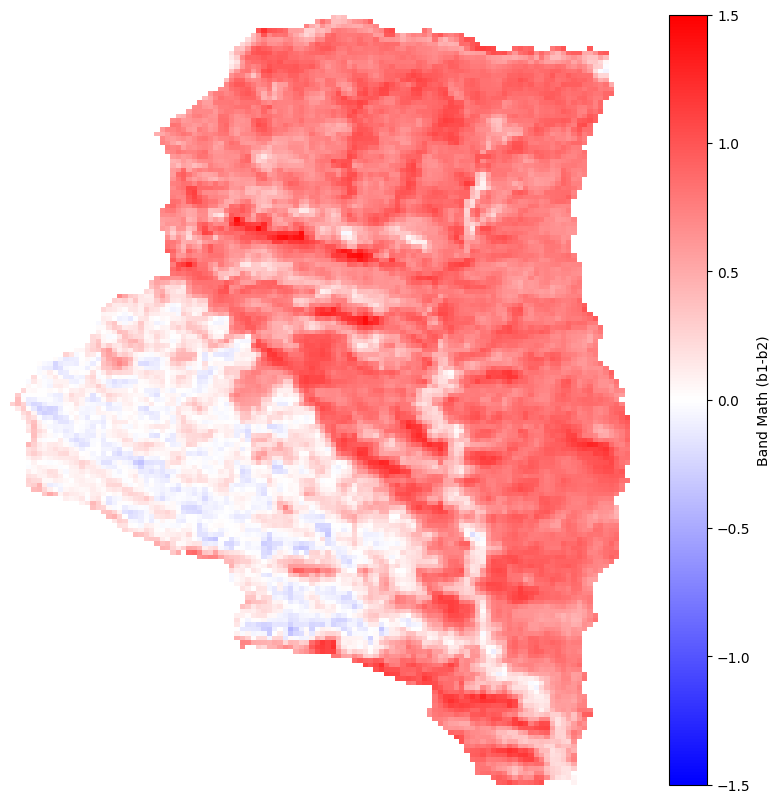

In [39]:
plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt
AV_OdNBR_I.plot(cmap='bwr', vmin=-1.5, vmax=1.5)
plt.axis('off')
plt.title('')


plt.savefig(os.path.join(out2, 'AVIRIS_OHdNBR.svg'), bbox_inches='tight', pad_inches=0.1, dpi=600)